## 混合ガウスモデルに基づくクラスタリング


120
30
[[5.  2.  3.5 1. ]
 [5.9 3.  4.2 1.5]
 [6.  2.2 4.  1. ]
 [6.1 2.9 4.7 1.4]
 [5.6 2.9 3.6 1.3]
 [6.7 3.1 4.4 1.4]
 [5.6 3.  4.5 1.5]
 [5.8 2.7 4.1 1. ]
 [6.2 2.2 4.5 1.5]
 [5.6 2.5 3.9 1.1]
 [5.9 3.2 4.8 1.8]
 [6.1 2.8 4.  1.3]
 [6.3 2.5 4.9 1.5]
 [6.1 2.8 4.7 1.2]
 [6.4 2.9 4.3 1.3]
 [6.6 3.  4.4 1.4]
 [6.8 2.8 4.8 1.4]
 [6.7 3.  5.  1.7]
 [6.  2.9 4.5 1.5]
 [5.7 2.6 3.5 1. ]
 [5.5 2.4 3.8 1.1]
 [5.5 2.4 3.7 1. ]
 [5.8 2.7 3.9 1.2]
 [6.  2.7 5.1 1.6]
 [5.4 3.  4.5 1.5]
 [6.  3.4 4.5 1.6]
 [6.7 3.1 4.7 1.5]
 [6.3 2.3 4.4 1.3]
 [5.6 3.  4.1 1.3]
 [5.5 2.5 4.  1.3]
 [5.5 2.6 4.4 1.2]
 [6.1 3.  4.6 1.4]
 [5.8 2.6 4.  1.2]
 [5.  2.3 3.3 1. ]
 [5.6 2.7 4.2 1.3]
 [5.7 3.  4.2 1.2]
 [5.7 2.9 4.2 1.3]
 [6.2 2.9 4.3 1.3]
 [5.1 2.5 3.  1.1]
 [5.7 2.8 4.1 1.3]]
[array([5.0425, 3.4575, 1.465 , 0.2525])]


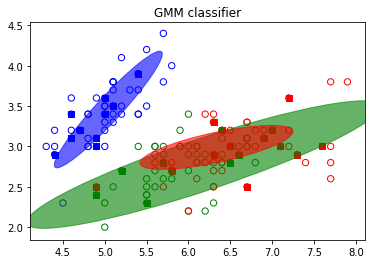

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

# よくあるアヤメのデータセット
iris = datasets.load_iris()

# アヤメのデータセットの詳細説明
#print(iris.DESCR)
#print(iris)

# アヤメのデータセット
# data：ガクの長さ、ガクの幅、花弁の長さ、花弁の幅
# target: ラベル（0(=setosa), 1(=versicolor), 2(=virginica) のどれか）

# データを５（n_splits=5）分割しておく
# indicesには5分割された[iris.dataリスト, iris.targetリスト]が入っている
indices = StratifiedKFold(n_splits=5).split(iris.data, iris.target)

# debug
#print ("=== indices ===")
#for i, item in enumerate(indices):
#    print(i)
#    print(item)
#print ("======")

# 最初のサブグループを取得する
train_index, test_index = next(iter(indices))

# 全部で150個のデータが訓練用(train_indexは120個)、テスト用(test_indexは30個)に分けられる
print(len(train_index))
print(len(test_index))

# 訓練用データとラベルを取得する
X_train = iris.data[train_index]
y_train = iris.target[train_index]

# 検証用データとラベルを取り出す
X_test = iris.data[test_index]
y_test = iris.target[test_index]

# 訓練用データのクラス数を求める
num_classes = len(np.unique(y_train))

# 金剛ガウスモデル(GaussianMixture)を作成する
# n_components：確率分布の数
# covariance_type：共分散の種類
# init_params：重みと平均を初期化する方法
# max_iter：訓練中の期待値最大化処理の繰り返し回数
gmm = GaussianMixture(n_components=num_classes, covariance_type='full',
                        init_params='random', random_state=0, max_iter=20)

# GMMの平均値を初期化する（ちょっと意味わからない。。）
# それぞれのラベルyに対する入力値Xの列毎（データ項目毎）の平均を取っている
gmm.means_init = np.array([X_train[y_train==i].mean(axis=0)
                            for i in range(num_classes)])
print(gmm.means_init)
# 訓練
gmm.fit(X_train)

# クラスタ境界を可視化する
# 固有値と固有ベクトルを取り出して、クラスタ周辺に楕円形の境界線を描画する
plt.figure()
axis_handle = plt.subplot(1, 1, 1)
colors = 'bgr'
for i, color in enumerate(colors):
    eigenvalues, eigenvectors = np.linalg.eigh(gmm.covariances_[i][:2, :2])
    
    # 第１成分の固有ベクトルを正規化する
    norm_vec = eigenvectors[0] / np.linalg.norm(eigenvectors[0])

    # 分布を正確に表現するために楕円形を回転させる必要があるので、角度を計算する
    angle = np.arctan2(norm_vec[1], norm_vec[0])
    angle = 180 * angle / np.pi

    # 可視化のため楕円形を拡大する。固有値が楕円形の大きさを表す。
    # 拡大率の8は適当
    scaling_factor = 8
    eigenvalues *= scaling_factor

    # 楕円形を描画する
    ellipse = patches.Ellipse(gmm.means_[i, :2],
                            eigenvalues[0], eigenvalues[1], 180 + angle, color=color)
    ellipse.set_clip_box(axis_handle.bbox)
    ellipse.set_alpha(0.6)
    axis_handle.add_artist(ellipse)
    
# 入力データを○で表示する
for i, color in enumerate(colors):
    cur_data = iris.data[iris.target == i]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker='o',
                facecolors='none', edgecolor=color, s=40,
                label=iris.target_names[i])
    
    # テストデータを■で表示する
    test_data = X_test[y_test == i]
    plt.scatter(test_data[:, 0], test_data[:, 1], marker='s',
                facecolors=color, edgecolor=color, s=40,
                label=iris.target_names[i])

plt.title('GMM classifier')
plt.show()

In [39]:
y_train_pred = gmm.predict(X_train)
accuracy_training = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
print('Accuracy on training data =', accuracy_training) 

y_test_pred = gmm.predict(X_test)
accuracy_testing = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
print('Accuracy on testing data =', accuracy_testing) 

Accuracy on training data = 87.5
Accuracy on testing data = 86.66666666666667
